1. FETCHING DATA WITH NEWS API

In [1]:
#installing reuired packages

In [2]:
pip install requests

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install newsapi-python

Note: you may need to restart the kernel to use updated packages.


In [1]:
#importing the NewsApiClient class from the newsapi
import requests
from newsapi import NewsApiClient

In [2]:
#initializing the client with my API key
newsapi = NewsApiClient(api_key='c0cf865f65824d37b1aae9f7a6513f50')

In [3]:
#calling the method 'get_top_headlines' of the 'newsapi' object to retrieve the top headlines.
top_headlines = newsapi.get_top_headlines(q='war OR military',
                                          category='general',  # Adjust as needed
                                          language='en',
                                          country='us')  # Adjust the country as needed

In [4]:
#importing thedatetime class from the datetime, timedelta
from datetime import datetime, timedelta

#setting the date range 
to_date = datetime.now()
from_date = to_date - timedelta(days=30)

#returning a collection of top headlines that fit the specified criteria 
c = newsapi.get_everything(q='war OR military',
                                      domains='bbc.co.uk, cnn.com', 
                                      from_param=from_date.strftime('%Y-%m-%d'), 
                                      to=to_date.strftime('%Y-%m-%d'),
                                      language='en',
                                      sort_by='relevancy',
                                      page=1)

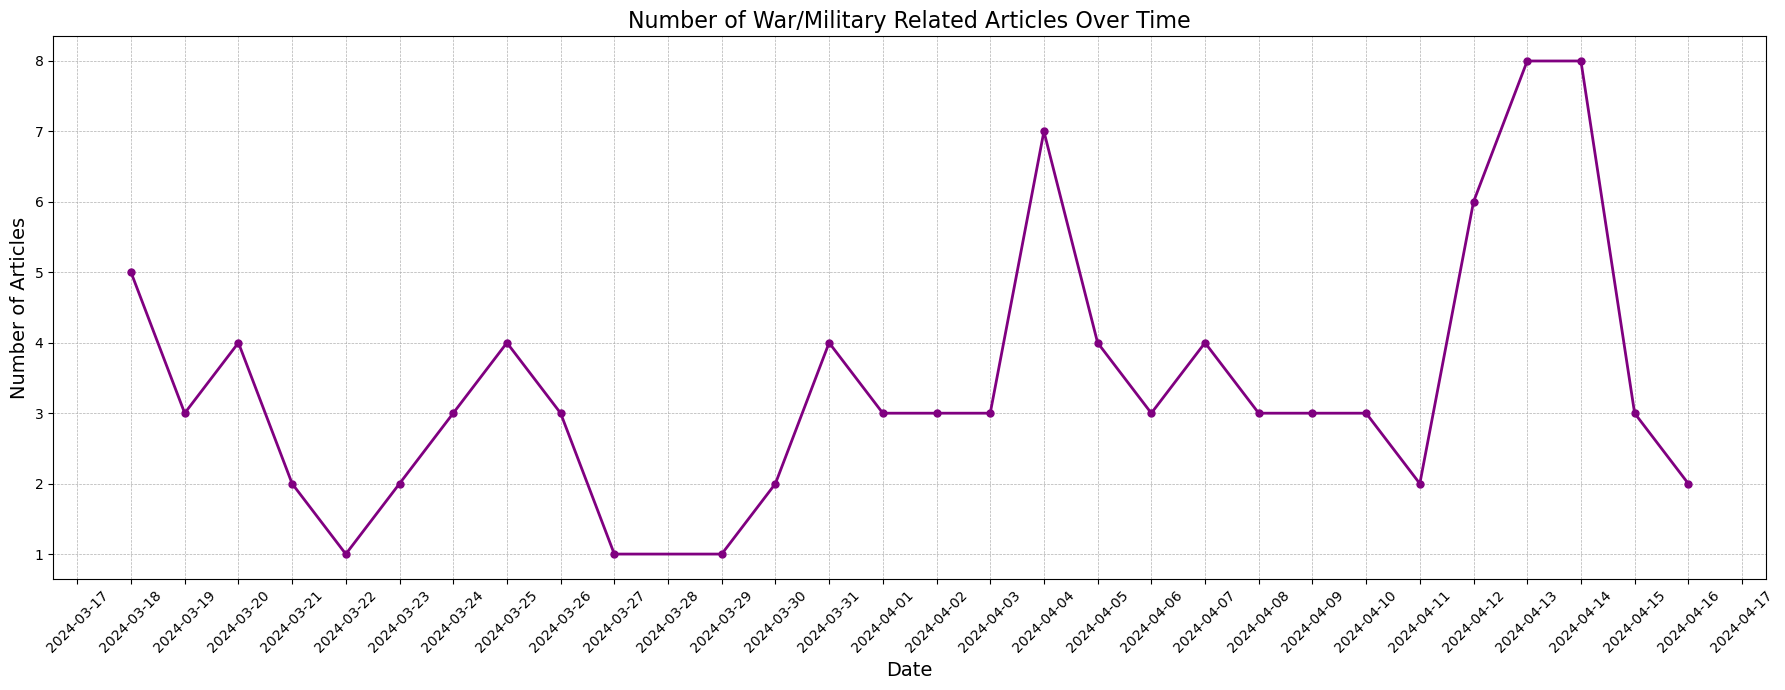

In [5]:
#importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#converting articles and 'publishedAt into the DataFrame
articles_data = [{'title': article['title'], 'publishedAt': 
                  article['publishedAt']} for article in c['articles']]
df_articles = pd.DataFrame(articles_data)
df_articles['publishedAt'] = pd.to_datetime(df_articles['publishedAt']).dt.date

#counting articles by date
article_counts = df_articles.groupby('publishedAt').size().reset_index(name='counts')

#plotting
plt.figure(figsize=(18, 7))  
plt.plot(article_counts['publishedAt'], article_counts['counts'], 
         marker='o', linestyle='-', color='purple', linewidth=2, markersize=5)
plt.title('Number of War/Military Related Articles Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Articles', fontsize=14)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

2. WEBSCRAPPING FROM WIKI

In [6]:
#importing necessary libraries
import requests
from bs4 import BeautifulSoup

#setting URL of the Wikipedia page
url = 'https://en.wikipedia.org/wiki/List_of_wars:_2003–present'

#sending a GET request to the page
response = requests.get(url)

#parsing the HTML content
soup = BeautifulSoup(response.text, 'html.parser')

#adjusting 'wikitable' to the correct class
tables = soup.find_all('table', class_='wikitable')

#asigning list to hold all wars data
wars_data = []

#going through all found tables using the loop
for table in tables:
    #finding all row tags in the table, skip the first one as it's usually the header
    for row in table.find_all('tr')[1:]:
        cells = row.find_all('td')
        if cells:
            #adjusting the indexes below according to the actual table structure
            start_year = cells[0].text.strip()
            end_year = cells[1].text.strip()
            name_of_conflict = cells[2].text.strip()
            #appending a tuple with all the extracted data for this row to the wars_data
            wars_data.append((start_year, end_year, name_of_conflict))

#cleaning the '\n' and any subsequent text from the 'Name of Conflict' column
df_wars = pd.DataFrame(wars_data, columns=['Start Year', 'End Year', 'Name of Conflict'])
df_wars['Name of Conflict'] = df_wars['Name of Conflict'].str.replace(r'\n.*', 
                                                                      '', regex=True)

#display the DataFrame first rows
df_wars.head()

,Start Year,End Year,Name of Conflict
0,2003,2020,War in Darfur
1,2003,2011,Iraq War
2,2004,2010,Sinaloa Cartel–Gulf Cartel conflict
3,2004,Ongoing,South Thailand insurgency
4,2004,Ongoing,Insurgency in Khyber Pakhtunkhwa


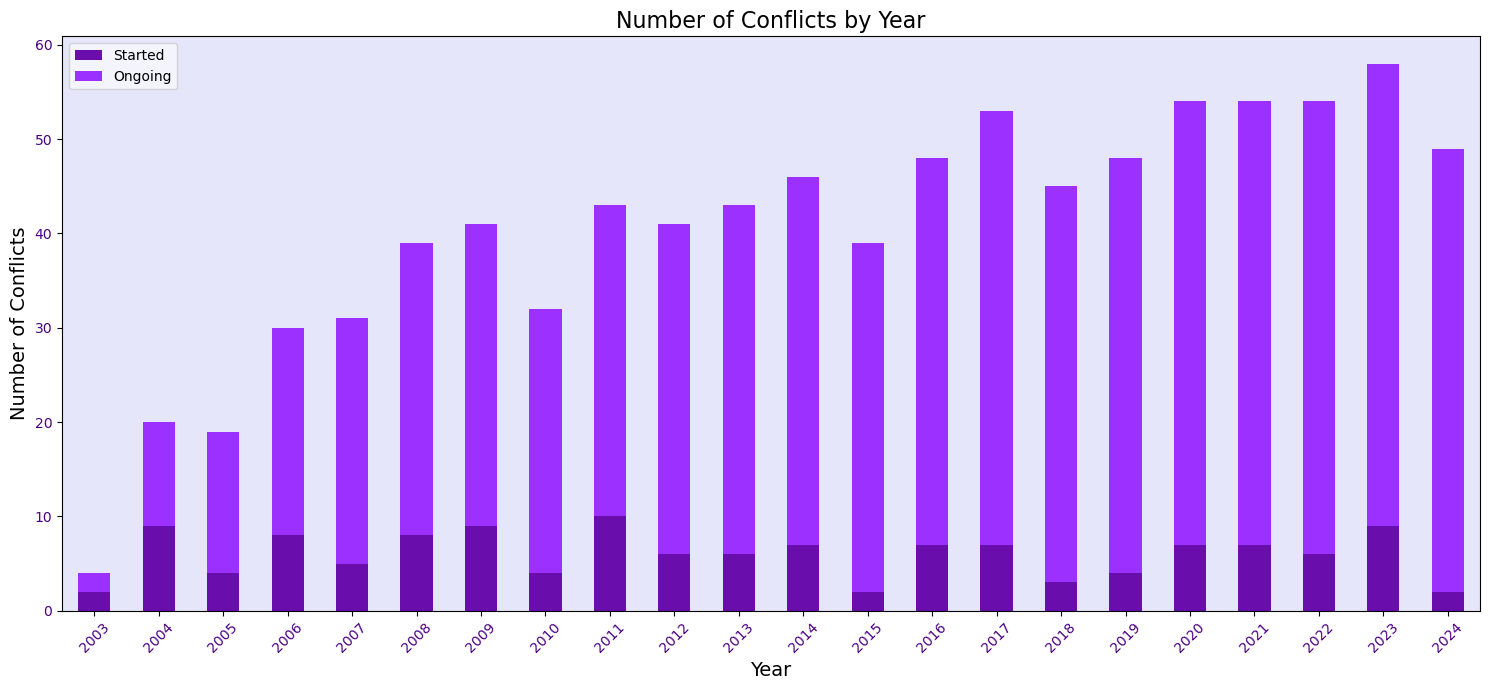

In [7]:
#replacing 'Ongoing' with the current year for ongoing conflicts
current_year = pd.to_datetime('now').year
df_wars['End Year'] = df_wars['End Year'].replace('Ongoing', current_year)

#converting years to numeric
df_wars['Start Year'] = pd.to_numeric(df_wars['Start Year'])
df_wars['End Year'] = pd.to_numeric(df_wars['End Year'])

#creating a range of years from the earliest 'Start Year' to the current year
years = range(df_wars['Start Year'].min(), current_year + 1)

#initialising a DataFrame to hold the count of started and ongoing conflicts per year
conflicts_per_year = pd.DataFrame(index=years, columns=['Started', 'Ongoing', 'Ended'])

#counting the number of conflicts that started, were ongoing, and ended each year
for year in years:
    conflicts_per_year.loc[year, 'Started'] = df_wars['Start Year'].eq(year).sum()
    conflicts_per_year.loc[year, 'Ongoing'] = df_wars[df_wars['Start Year'].le(year) 
                                                      & df_wars['End Year'].ge(year)].shape[0]
    conflicts_per_year.loc[year, 'Ended'] = df_wars['End Year'].eq(year).sum()

#converting all counts to integers
conflicts_per_year = conflicts_per_year.astype(int)

#plotting
colors = ['#6a0dad', '#9b30ff']
conflicts_per_year[['Started', 'Ongoing']].plot(kind='bar',
                                                stacked=True, color=colors, figsize=(15, 7))
plt.title('Number of Conflicts by Year', fontsize=16) 
plt.xlabel('Year', fontsize=14)  
plt.ylabel('Number of Conflicts', fontsize=14)
plt.xticks(rotation=45, color='#4b0082')
plt.yticks(color='#4b0082') 
ax = plt.gca()  
ax.set_facecolor('#e6e6fa')  
ax.legend(facecolor='#f8f8ff')  
plt.tight_layout()
plt.show()

3. WORKING WITH THE GDP AND MILITARY EXPENDITURES 

3.1. Government military expenditure

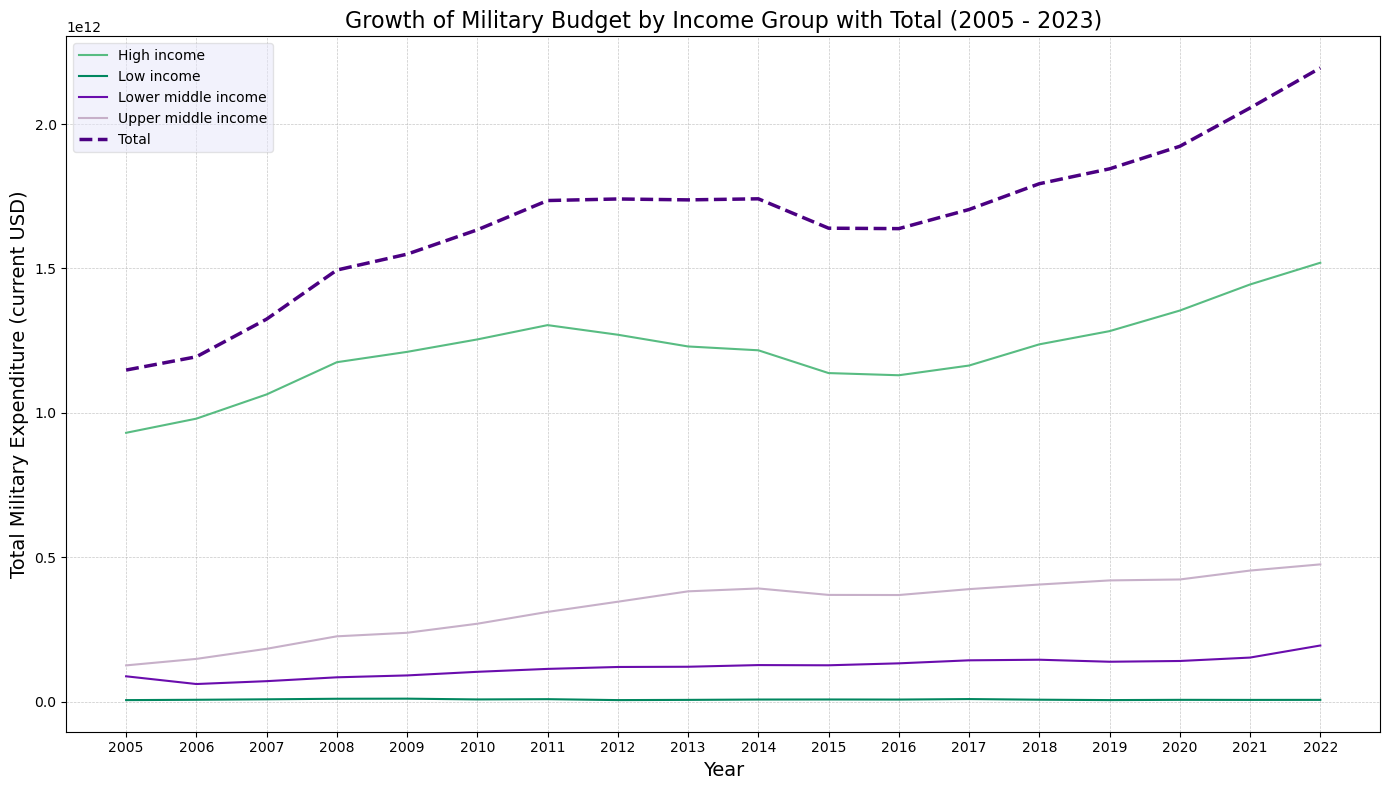

In [8]:
#loading the data
country_metadata = pd.read_csv('Metadata_Country_API_MS.MIL.XPND.CD_DS2_en_csv_v2_47475.csv')
expenditure_data = pd.read_csv('API_MS.MIL.XPND.CD_DS2_en_csv_v2_47475.csv', skiprows=4)

#merging the DataFrames
merged_data = pd.merge(expenditure_data, country_metadata[['Country Code', 
                                                           'IncomeGroup']], on='Country Code')

#filtering 
years = [str(year) for year in range(2005, 2023)]
merged_data = merged_data[['Country Code', 'IncomeGroup'] + years]

#melting the data so that years are in a single column
melted_data = merged_data.melt(id_vars=['Country Code', 'IncomeGroup'], 
                               value_vars=years, var_name='Year', value_name='Expenditure')

#grouping by IncomeGroup and Year and summing 
grouped_data = melted_data.groupby(['IncomeGroup', 'Year']).sum().reset_index()

#pivotting
pivot_data = grouped_data.pivot(index='Year', columns='IncomeGroup', values='Expenditure')

#calculating the total expenditure across all income groups for each year
pivot_data['Total'] = pivot_data.sum(axis=1)

#defining shades for the visualisation
purple_shades = ['#58BC82', '#01875f', '#6a0dad', '#c7b0c9', '#d7c3db']

#plotting
plt.figure(figsize=(14, 8))
for (i, column) in enumerate(pivot_data.columns.drop('Total')):
    plt.plot(pivot_data.index, pivot_data[column], label=column, color=purple_shades[i])
plt.plot(pivot_data.index, pivot_data['Total'], label='Total', 
         color='indigo', linestyle='--', linewidth=2.5)
plt.title('Growth of Military Budget by Income Group with Total (2005 - 2023)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Total Military Expenditure (current USD)', fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(framealpha=0.5,  facecolor='lavender')
plt.tight_layout()  
plt.show()

3.2. GDP

In [9]:
#loading the data
metadata_country_path = 'Metadata_Country_API_NY.GDP.MKTP.CD_DS2_en_csv_v2_26.csv'
gdp_data_path = 'API_NY.GDP.MKTP.CD_DS2_en_csv_v2_26.csv'

#reading 
metadata_country_df = pd.read_csv(metadata_country_path)
gdp_data_df = pd.read_csv(gdp_data_path, skiprows=4)

#filteing to keep only necessary columns
gdp_data_df = gdp_data_df[['Country Code', 'Indicator Name', '2005', '2006', '2007', '2008', 
                           '2009', '2010','2011','2012', '2013','2014','2015', '2016', '2017', '2018', 
                           '2019', '2020', '2021', '2022']]

#merging
merged_gdp_data = pd.merge(gdp_data_df, metadata_country_df[['Country Code', 'IncomeGroup']], on='Country Code')

#droping the Indicator Name column as it's not needed
merged_gdp_data.drop(columns=['Indicator Name', 'Country Code'], inplace=True)

#grouping by income and summing the GDPs for each year
grouped_gdp_data = merged_gdp_data.groupby('IncomeGroup').sum().reset_index()

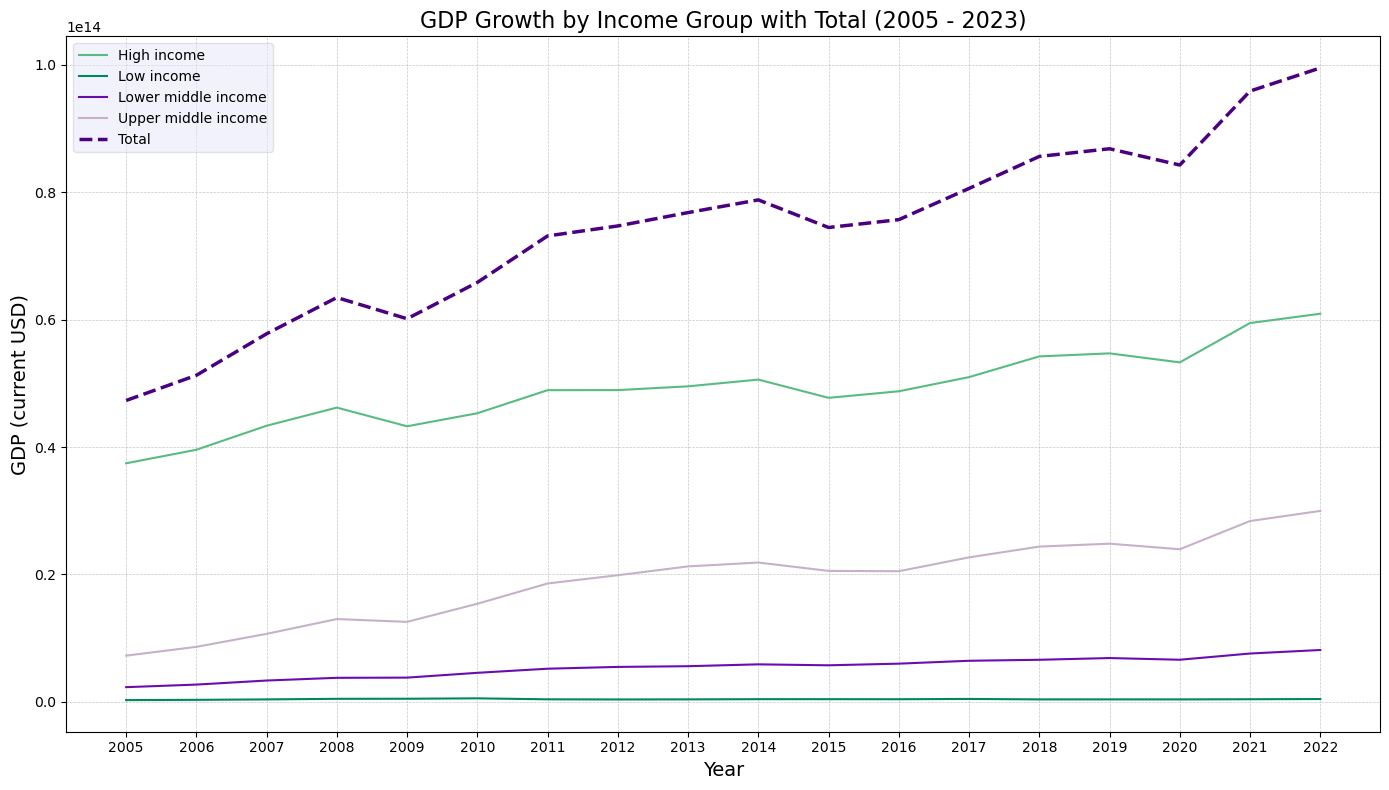

In [10]:
#grouping by IncomeGroup and Year and summing the Expenditures
grouped_gdp_data = merged_gdp_data.groupby('IncomeGroup')[years].sum()

#transposing the DataFrame to have years as rows
transposed_grouped_gdp_data = grouped_gdp_data.T

#adding a 'Total' column that sums all income groups for each year
transposed_grouped_gdp_data['Total'] = transposed_grouped_gdp_data.sum(axis=1)

#plotting
plt.figure(figsize=(14, 8))
for (i, column) in enumerate(transposed_grouped_gdp_data.columns.drop('Total')):
    plt.plot(transposed_grouped_gdp_data.index, transposed_grouped_gdp_data[column], 
             label=column, color=purple_shades[i])
plt.plot(transposed_grouped_gdp_data.index, transposed_grouped_gdp_data['Total'], label='Total', 
         color='indigo', linestyle='--', linewidth=2.5)
plt.title('GDP Growth by Income Group with Total (2005 - 2023)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('GDP (current USD)', fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(framealpha=0.5,  facecolor='lavender')
plt.tight_layout()  
plt.show()

4. INVESTIGATING ETFs DATA

[*********************100%%**********************]  3 of 3 completed


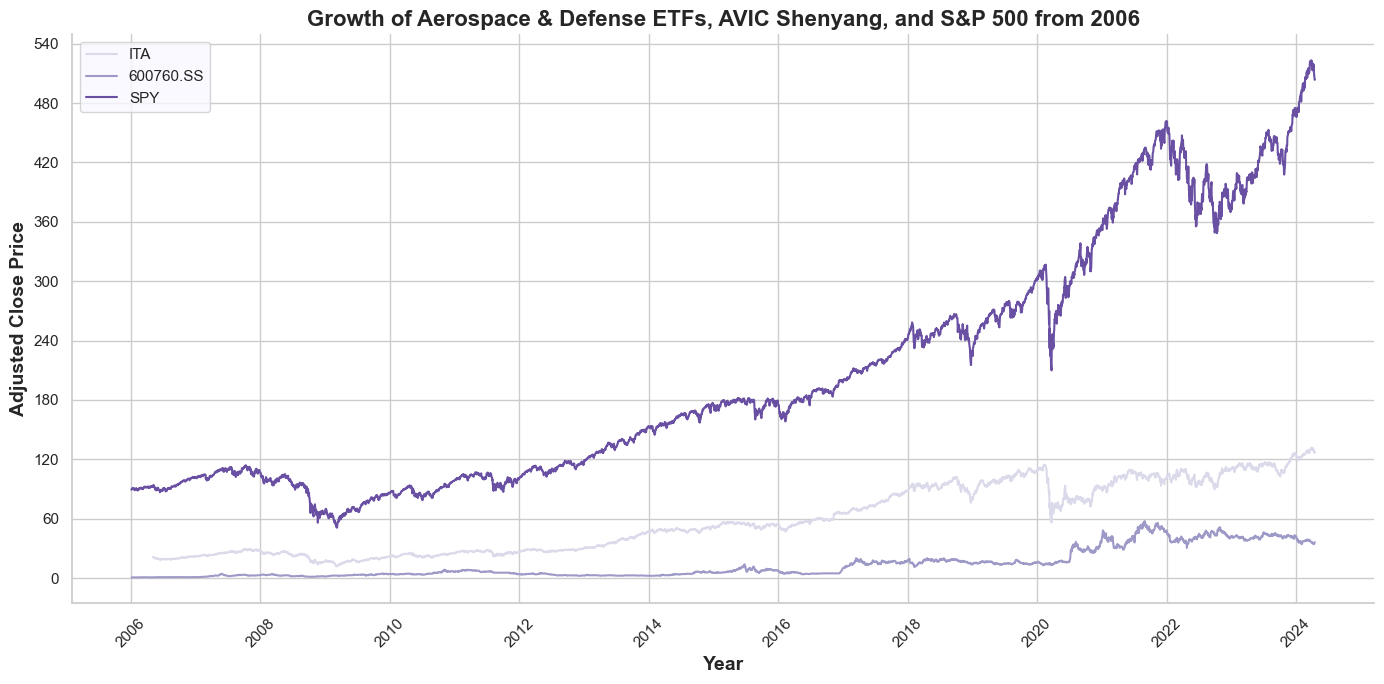

In [11]:
#importing necessary libraries
import yfinance as yf
from matplotlib.ticker import MaxNLocator
import seaborn as sns

#applying the certain style
sns.set(style='whitegrid')

#defining the tickers for the ETFs
tickers = ['ITA', '600760.SS', 'SPY']

#fetching historical data
etf_data = yf.download(tickers, start='2006-01-01')['Adj Close']

#аill any missing data forward
etf_data.ffill(inplace=True)

#plotting
plt.figure(figsize=(14, 7), facecolor='white')
purple_palette = sns.color_palette("Purples", len(tickers))
for i, ticker in enumerate(tickers):
    plt.plot(etf_data.index, etf_data[ticker], label=ticker, color=purple_palette[i])
plt.title('Growth of Aerospace & Defense ETFs, AVIC Shenyang, and S&P 500 from 2006', fontsize=16, weight='bold')
plt.xlabel('Year', fontsize=14, weight='bold')
plt.ylabel('Adjusted Close Price', fontsize=14, weight='bold')
plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=10))
plt.xticks(rotation=45)
sns.despine()
plt.legend(facecolor='#f8f8ff')
plt.tight_layout()
plt.savefig('etf_growth_chart.png', dpi=300)
plt.show()

5. INVESTIGATING THE RELATION BETWEEN THE NUMBER OF ARTICLES AND IT/600760.SS IN THE SHORT-TERM

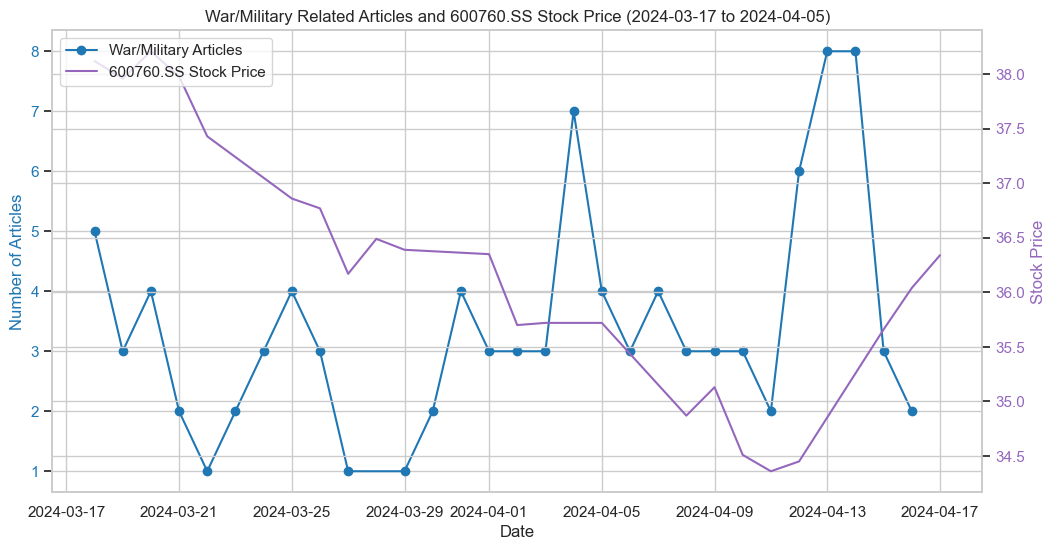

In [12]:
#resetting index to make the column 'Date'
etf_data.reset_index(inplace=True)
etf_data2 = etf_data[etf_data['Date'] > pd.to_datetime('2024-03-17')]

#plotting for 600760.SS
color = 'tab:blue'
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Articles', color=color)
ax1.plot(article_counts['publishedAt'], article_counts['counts'], color=color,
         marker='o', linestyle='-', label='War/Military Articles')
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  
color = 'tab:purple'
ax2.set_ylabel('Stock Price', color=color)
ax2.plot(etf_data2['Date'], etf_data2['600760.SS'], color=color, label='600760.SS Stock Price')
ax2.tick_params(axis='y', labelcolor=color)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')
plt.title('War/Military Related Articles and 600760.SS Stock Price (2024-03-17 to 2024-04-05)')
plt.show()

In [122]:
#converting to the correct datetime format
article_counts['publishedAt'] = pd.to_datetime(article_counts['publishedAt'])

#merging the article counts with stock data on date
merged_data = pd.merge(etf_data, article_counts, left_on='Date', right_on='publishedAt', how='left')

#calculating the median number of articles
median_articles = merged_data['counts'].median()

#categorising days based on the median
merged_data['Article_Level'] = ['High' if x > median_articles else 'Low' for x in merged_data['counts']]

#separating the stock prices into two groups based on article level
high_articles_stock_prices = merged_data[merged_data['Article_Level'] == 'High']['600760.SS']
low_articles_stock_prices = merged_data[merged_data['Article_Level'] == 'Low']['600760.SS']

#performing the t-test
t_stat, p_value = ttest_ind(high_articles_stock_prices.dropna(), low_articles_stock_prices.dropna(), 
                            equal_var=False)

#printing the results
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: 35.275251321805335, P-value: 1.7341331535276515e-08


In [126]:
correlation_coefficient = merged_data[['counts', '600760.SS']].corr().iloc[0, 1]
print("Correlation Coefficient:", correlation_coefficient)

Correlation Coefficient: -0.09900984905878521


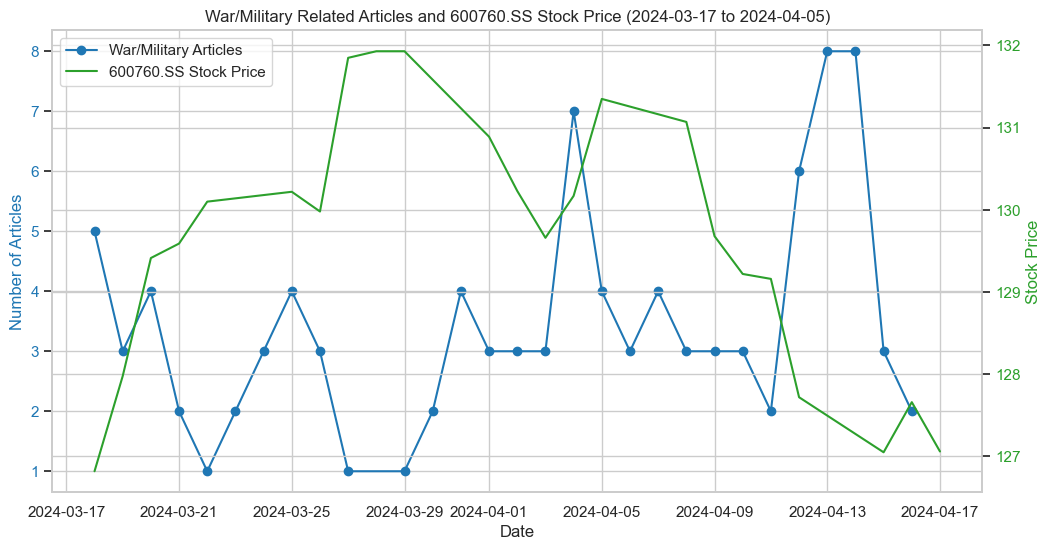

In [13]:
#plotting for ITA
color = 'tab:blue'
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Articles', color=color)
ax1.plot(article_counts['publishedAt'], article_counts['counts'], color=color, 
         marker='o', linestyle='-', label='War/Military Articles')
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  
color = 'tab:green'
ax2.set_ylabel('Stock Price', color=color)
ax2.plot(etf_data2['Date'], etf_data2['ITA'], color=color, label='600760.SS Stock Price')
ax2.tick_params(axis='y', labelcolor=color)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')
plt.title('War/Military Related Articles and 600760.SS Stock Price (2024-03-17 to 2024-04-05)')
plt.show()

In [121]:
#converting to the correct datetime format
article_counts['publishedAt'] = pd.to_datetime(article_counts['publishedAt'])

#merging the article counts with stock data on date
merged_data = pd.merge(etf_data, article_counts, left_on='Date', right_on='publishedAt', how='left')

#calculating the median number of articles
median_articles = merged_data['counts'].median()

#categorising days based on the median
merged_data['Article_Level'] = ['High' if x > median_articles else 'Low' for x in merged_data['counts']]

#separating the stock prices into two groups based on article level
high_articles_stock_prices = merged_data[merged_data['Article_Level'] == 'High']['ITA']
low_articles_stock_prices = merged_data[merged_data['Article_Level'] == 'Low']['ITA']

#performing the t-test
t_stat, p_value = ttest_ind(high_articles_stock_prices.dropna(), low_articles_stock_prices.dropna(), 
                            equal_var=False)

#printing the results
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: 81.92298253544197, P-value: 2.081848368794766e-17


In [127]:
correlation_coefficient = merged_data[['counts', 'ITA']].corr().iloc[0, 1]
print("Correlation Coefficient:", correlation_coefficient)

Correlation Coefficient: -0.3230294400459498


6. INVESTIGATING THE RELATIONS BETWEEN THE VARIABLEs

6.1. Prepating the data

In [14]:
#aggregating mock conflict data to yearly
conflicts_per_year = df_wars['Start Year'].value_counts().sort_index()
conflicts_per_year.index = pd.to_numeric(conflicts_per_year.index)

#ensuring that 'Year' is a column in pivot_data
pivot_data.reset_index(inplace=True)

#converting the 'Year' column to int
pivot_data['Year'] = pivot_data['Year'].astype(int)
conflicts_per_year = conflicts_per_year.reset_index()
conflicts_per_year['Start Year'] = conflicts_per_year['Start Year'].astype(int)

#renaming the columns
conflicts_per_year.rename(columns={'Start Year': 'Year', 'count': 'Started Conflicts'}, inplace=True)

#merging the DataFrames on 'Year'
summary_data_EXP = pd.merge(pivot_data, conflicts_per_year, how='left', left_on='Year', right_on='Year')

#resetying the index to turn the 'Year' index into a regular column
transposed_grouped_gdp_data.reset_index(inplace=True)

#renaming the column
transposed_grouped_gdp_data.rename(columns={transposed_grouped_gdp_data.columns[0]: 'Year'}, inplace=True)

#converting the column into the integers
transposed_grouped_gdp_data['Year'] = transposed_grouped_gdp_data['Year'].astype(int)

#merging the tables
final_data = pd.merge(summary_data_EXP, transposed_grouped_gdp_data, on='Year', how='left')

In [130]:
#preparing the etf_data by extracting the year and getting the mean values per year
etf_data['Year'] = pd.to_datetime(etf_data['Date']).dt.year
annual_etf_mean = etf_data.groupby('Year').agg({'600760.SS': 'mean', 'ITA': 'mean', 'SPY': 'mean'}).reset_index()

#merging the tables
final_data2 = pd.merge(final_data, annual_etf_mean, on='Year', how='outer')

#creating a dictionary where key is the old name and value is the new name
rename_dict = {col: col.replace('_x', ' GovExp') for col in final_data.columns if col.endswith('_x')}
rename_dict.update({col: col.replace('_y', ' GDP') for col in final_data.columns if col.endswith('_y')})

#renaming the columns using the dictionary
final_data2.rename(columns=rename_dict, inplace=True)

#displaying the results
final_data2

,Year,High income GovExp,Low income GovExp,Lower middle income GovExp,Upper middle income GovExp,Total GovExp,Started Conflicts,High income GDP,Low income GDP,Lower middle income GDP,Upper middle income GDP,Total GDP,600760.SS,ITA,SPY
0,2005,9.308266e+11,4.868986e+09,8.734631e+10,1.251883e+11,1.148230e+12,4.0,3.744838e+13,2.823606e+11,2.315097e+12,7.259907e+12,4.730575e+13,NaN,NaN,NaN
1,2006,9.798676e+11,6.025367e+09,6.060271e+10,1.476864e+11,1.194182e+12,8.0,3.957145e+13,3.264168e+11,2.718605e+12,8.643659e+12,5.126013e+13,0.940083,20.188283,93.178907
2,2007,1.063769e+12,7.650629e+09,7.051495e+10,1.826545e+11,1.324589e+12,5.0,4.334337e+13,3.928480e+11,3.355447e+12,1.068115e+13,5.777282e+13,2.514298,25.788437,106.886432
3,2008,1.175363e+12,9.555957e+09,8.385515e+10,2.258397e+11,1.494614e+12,8.0,4.619007e+13,4.855480e+11,3.782293e+12,1.300467e+13,6.346258e+13,2.425942,22.569929,89.972231
4,2009,1.211216e+12,9.898678e+09,9.039465e+10,2.381505e+11,1.549660e+12,9.0,4.325901e+13,4.986541e+11,3.812693e+12,1.256351e+13,6.013387e+13,3.197246,17.788429,71.932729
5,2010,1.254323e+12,7.232615e+09,1.029150e+11,2.694795e+11,1.633950e+12,4.0,4.530384e+13,5.606540e+11,4.566635e+12,1.540403e+13,6.583516e+13,4.892389,23.143633,88.216010
6,2011,1.303829e+12,8.141083e+09,1.130176e+11,3.104340e+11,1.735422e+12,10.0,4.892415e+13,4.077718e+11,5.212392e+12,1.858682e+13,7.313114e+13,6.409466,26.057055,99.999177
7,2012,1.270537e+12,4.920915e+09,1.196333e+11,3.457138e+11,1.740805e+12,6.0,4.893775e+13,3.842848e+11,5.492168e+12,1.988368e+13,7.469788e+13,3.559468,28.197722,111.115383
8,2013,1.229915e+12,5.681351e+09,1.204480e+11,3.816541e+11,1.737699e+12,6.0,4.952682e+13,3.974798e+11,5.604827e+12,2.126849e+13,7.679762e+13,2.744819,37.385687,135.233644
9,2014,1.216667e+12,6.850828e+09,1.262249e+11,3.916254e+11,1.741368e+12,7.0,5.058713e+13,4.288529e+11,5.896071e+12,2.187459e+13,7.878664e+13,4.254672,48.747605,162.055639


6.2. Correlation matrix

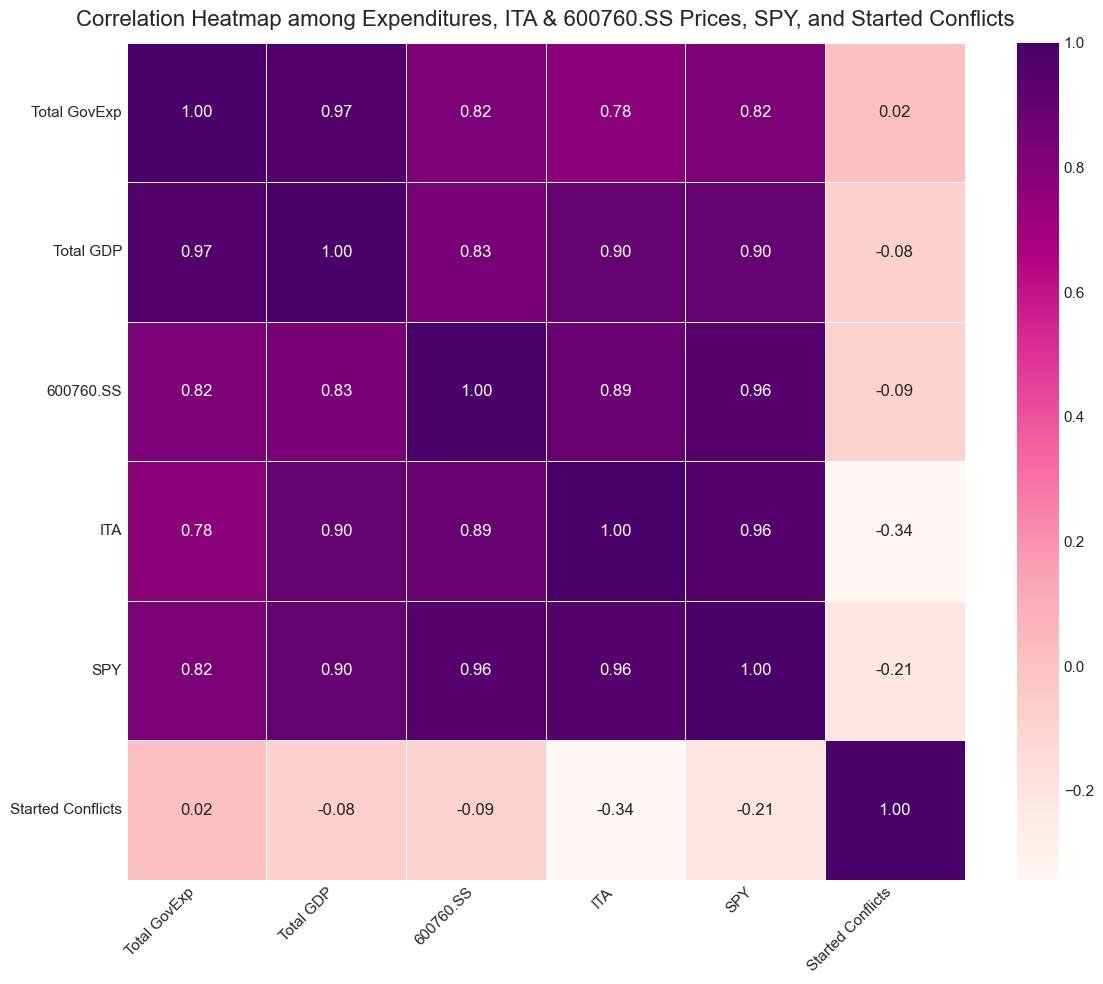

In [115]:
#calculate correlation matrix
correlation_matrix = final_data2[['Total GovExp', 'Total GDP', '600760.SS', 'ITA', 'SPY', 'Started Conflicts']].corr()

#plotting
purple_gradient = sns.color_palette("RdPu", as_cmap=True)  
plt.figure(figsize=(12, 10))  
sns.heatmap(correlation_matrix, annot=True, cmap=purple_gradient, fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap among Expenditures, ITA & 600760.SS Prices, SPY, and Started Conflicts', 
          fontsize=16, pad=12)
plt.xticks(rotation=45, ha='right') 
plt.yticks(rotation=0) 
plt.tight_layout() 
plt.show()

6.3. Bivariate regression model

In [48]:
#importing necessary libraries
import statsmodels.api as sm

#defining our groups
income_groups = ['High income GovExp', 'Low income GovExp', 'Lower middle income GovExp', 
                 'Upper middle income GovExp']

#running regression for ITA
print("ITA Regression Results:")
for group in income_groups:
    X = final_data2[group]
    y = final_data2['ITA']  
    X = sm.add_constant(X) 
    model = sm.OLS(y, X, missing='drop').fit()  
    print(f"\n{group}:")
    print(model.summary())

ITA Regression Results:

High income GovExp:
                            OLS Regression Results                            
Dep. Variable:                    ITA   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     8.670
Date:                Wed, 17 Apr 2024   Prob (F-statistic):             0.0100
Time:                        18:07:56   Log-Likelihood:                -78.748
No. Observations:                  17   AIC:                             161.5
Df Residuals:                      15   BIC:                             163.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

/Users/mariiaboiko/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/mariiaboiko/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/mariiaboiko/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/mariiaboiko/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/mariiaboiko/anaconda3/lib/python3.11/site-packages/scipy/stats/_s

In [49]:
#running regression for 600760.SS
print("\n600760.SS Regression Results:")
for group in income_groups:
    X = final_data2[group]  
    y = final_data2['600760.SS'] 
    X = sm.add_constant(X) 
    model = sm.OLS(y, X, missing='drop').fit()
    print(f"\n{group}:")
    print(model.summary())


600760.SS Regression Results:

High income GovExp:
                            OLS Regression Results                            
Dep. Variable:              600760.SS   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     26.37
Date:                Wed, 17 Apr 2024   Prob (F-statistic):           0.000122
Time:                        18:11:12   Log-Likelihood:                -58.838
No. Observations:                  17   AIC:                             121.7
Df Residuals:                      15   BIC:                             123.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

/Users/mariiaboiko/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/mariiaboiko/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/mariiaboiko/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/mariiaboiko/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


6.4. Multivatiate regression analysis

In [78]:
#importing necessary libraries
import statsmodels.formula.api as smf

#defining regression with all the variables
formula_str2 = 'Q("600760.SS")  ~ Q("Low income GDP") + Q("Low income GovExp") + Q("Lower middle income GovExp") + Q("Lower middle income GDP") + Q("Upper middle income GovExp") + Q("Upper middle income GDP") + Q("High income GovExp") + Q("High income GDP") + SPY + Q("Started Conflicts")'

#running OLS aregression
modelA = smf.ols(formula=formula_str2, data=final_data2).fit()

#printing the results
print(modelA.summary())

                            OLS Regression Results                            
Dep. Variable:         Q("600760.SS")   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     126.9
Date:                Wed, 17 Apr 2024   Prob (F-statistic):           6.47e-07
Time:                        18:42:37   Log-Likelihood:                -24.105
No. Observations:                  17   AIC:                             68.21
Df Residuals:                       7   BIC:                             76.54
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

/Users/mariiaboiko/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [74]:
from statsmodels.stats.diagnostic import het_breuschpagan

#running the Breusch-Pagan test
residuals = modelA.resid
model_exog = modelA.model.exog  
bp_test = het_breuschpagan(residuals, model_exog)
bp_statistic, bp_pvalue = bp_test[:2]

#printing the results
print('Breusch-Pagan statistic:', bp_statistic)
print('Breusch-Pagan p-value:', bp_pvalue)

Breusch-Pagan statistic: 5.610255603508668
Breusch-Pagan p-value: 0.23020657449899787


In [79]:
#defining regression with the variables that have high t-statistics
formula_str3 = 'Q("600760.SS")  ~ Q("High income GovExp") + Q("High income GDP") + Q("Upper middle income GovExp") + Q("Upper middle income GDP") + SPY + Q("Started Conflicts")'

#running OLS aregression
modelB = smf.ols(formula=formula_str3, data=final_data2).fit()

#printing the results
print(modelB.summary())

                            OLS Regression Results                            
Dep. Variable:         Q("600760.SS")   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     120.3
Date:                Wed, 17 Apr 2024   Prob (F-statistic):           3.22e-09
Time:                        18:43:28   Log-Likelihood:                -33.292
No. Observations:                  17   AIC:                             78.58
Df Residuals:                      11   BIC:                             83.58
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

/Users/mariiaboiko/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [80]:
#defining regression with all the variables
formula_str4 = 'Q("ITA")  ~ Q("Low income GDP") + Q("Low income GovExp") + Q("Lower middle income GovExp") + Q("Lower middle income GDP") + Q("Upper middle income GovExp") + Q("Upper middle income GDP") + Q("High income GovExp") + Q("High income GDP") + SPY + Q("Started Conflicts")'

#running OLS aregression
modelC = smf.ols(formula=formula_str4, data=final_data2).fit()

#printing the results
print(modelC.summary())

                            OLS Regression Results                            
Dep. Variable:               Q("ITA")   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     20.23
Date:                Wed, 17 Apr 2024   Prob (F-statistic):           0.000329
Time:                        18:43:59   Log-Likelihood:                -54.610
No. Observations:                  17   AIC:                             129.2
Df Residuals:                       7   BIC:                             137.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

/Users/mariiaboiko/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [82]:
#defining regression with the variables that have high t-statistics
formula_str5 = 'Q("600760.SS")  ~ Q("High income GovExp") + Q("High income GDP") + Q("Lower middle income GovExp") + Q("Lower middle income GDP") + SPY + Q("Started Conflicts")'

#running OLS aregression
modelD = smf.ols(formula=formula_str5, data=final_data2).fit()

#printing the results
print(modelD.summary())

                            OLS Regression Results                            
Dep. Variable:         Q("600760.SS")   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     50.41
Date:                Wed, 17 Apr 2024   Prob (F-statistic):           3.26e-07
Time:                        18:46:22   Log-Likelihood:                -40.478
No. Observations:                  17   AIC:                             92.96
Df Residuals:                      11   BIC:                             97.96
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

/Users/mariiaboiko/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [128]:
from statsmodels.stats.diagnostic import het_breuschpagan

#running the Breusch-Pagan test
residuals = modelD.resid
model_exog = modelD.model.exog  
bp_test = het_breuschpagan(residuals, model_exog)
bp_statistic, bp_pvalue = bp_test[:2]

#printing the results
print('Breusch-Pagan statistic:', bp_statistic)
print('Breusch-Pagan p-value:', bp_pvalue)

Breusch-Pagan statistic: 9.244359673433202
Breusch-Pagan p-value: 0.1602946535882237


6.5. Prediction of the perfomance 600760.SS and ITA for the next 5 years

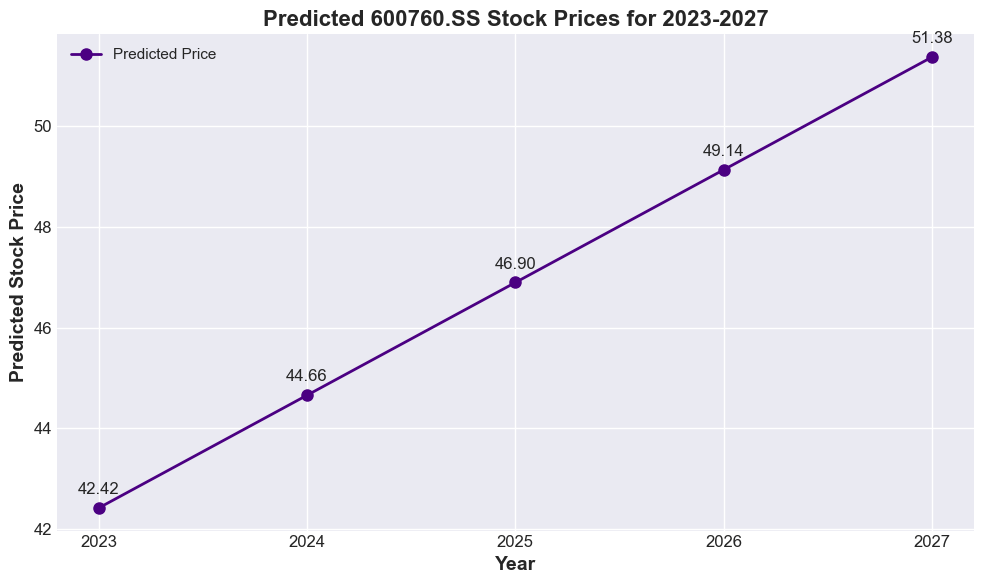

In [129]:
#defining future years to predict
future_years = np.arange(2023, 2028)  # Next 5 years

# defining placeholder DataFrame for the predictors
future_data = pd.DataFrame({
    'Year': future_years,
    'High income GovExp': np.linspace(1.519928e+12, 1.519928e+12 * 1.05, 5),  
    'High income GDP': np.linspace(6.092213e+13, 6.092213e+13 * 1.02, 5), 
    'Low income GDP': np.linspace(4.510040e+11, 4.510040e+11 * 1.03, 5),  
    'Low income GovExp': np.linspace(5.692947e+09, 5.692947e+09 * 1.07, 5), 
    'Lower middle income GDP': np.linspace(8.147631e+12, 8.147631e+12 * 1.06, 5),  
    'Lower middle income GovExp': np.linspace(1.940460e+11, 1.940460e+11 * 1.05, 5),  
    'Upper middle income GDP': np.linspace(2.997527e+13, 2.997527e+13 * 1.03, 5),  
    'Upper middle income GovExp': np.linspace(4.750442e+11, 4.750442e+11 * 1.05, 5), 
    'SPY': np.linspace(396.603937, 396.603937 * 1.2, 5), 
    'Started Conflicts': [6] * 5  
})

#adding Intercept column with all values as 1 for the constant term
future_data['Intercept'] = 1

#defining coefficients
coefficients = {
    'Intercept': -2.381e-05,
    'Lower middle income GDP': -3.842e-12,
    'Lower middle income GovExp': 7.673e-12,
    'High income GDP': -1.37e-12,
    'High income GovExp': 3.26e-11,
    'Low income GDP': 1.081e-11,
    'Low income GovExp': 1.014e-09,
    'Upper middle income GDP': 4.667e-12,
    'Upper middle income GovExp': -1.988e-10,
    'SPY': 0.1252,
    'Started Conflicts': 0.0644
}

#making predictions for the next 5 years using the regression coefficients
predicted_prices = []
for _, row in future_data.iterrows():
    predicted_price = sum(row[k] * v for k, v in coefficients.items())
    predicted_prices.append(predicted_price)

#adding the predictions to the DataFrame
future_data['Predicted_600760.SS_Price'] = predicted_prices

#plotting
color = '#4B0082' 
plt.figure(figsize=(10, 6))
plt.plot(future_data['Year'], future_data['Predicted_600760.SS_Price'], 
         marker='o', markersize=8, linestyle='-', linewidth=2, color=color, label='Predicted Price')
for i, txt in enumerate(future_data['Predicted_600760.SS_Price']):
    plt.annotate(f"{txt:.2f}", (future_data['Year'][i], 
                                future_data['Predicted_600760.SS_Price'][i]), 
                 textcoords="offset points", xytext=(0,10), ha='center')
plt.title('Predicted 600760.SS Stock Prices for 2023-2027', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.ylabel('Predicted Stock Price', fontsize=14, fontweight='bold')
plt.xticks(future_data['Year'], fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

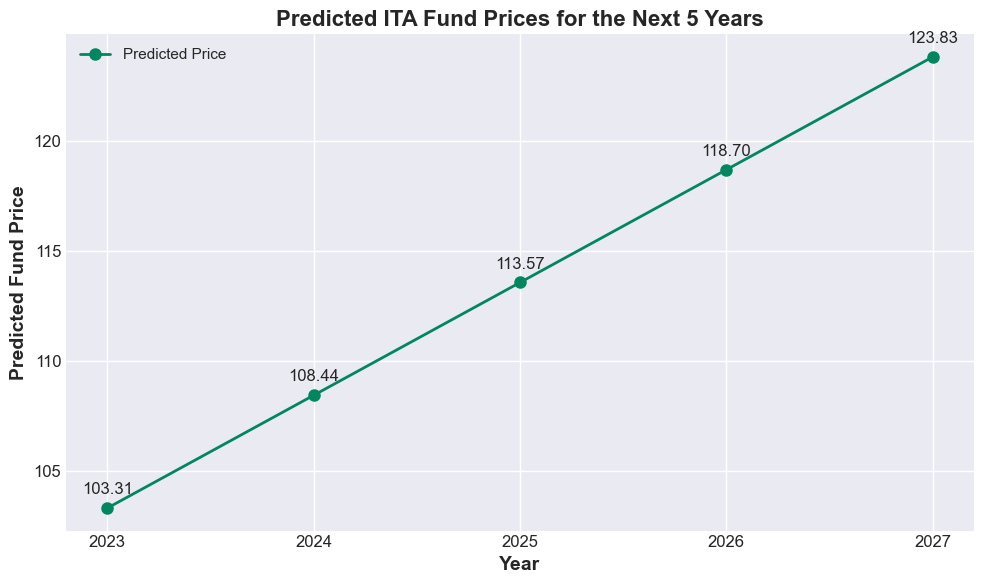

In [119]:
#defining future years to predict
future_years = np.arange(2023, 2028)  # Next 5 years

#defining placeholder DataFrame for the predictors
future_data = pd.DataFrame({
    'Year': future_years,
    'High income GovExp': np.linspace(1.519928e+12, 1.519928e+12 * 1.05, 5),
    'High income GDP': np.linspace(6.092213e+13, 6.092213e+13 * 1.02, 5),  
    'Low income GDP': np.linspace(4.510040e+11, 4.510040e+11 * 1.03, 5), 
    'Low income GovExp': np.linspace(5.692947e+09, 5.692947e+09 * 1.07, 5),  
    'Lower middle income GDP': np.linspace(8.147631e+12, 8.147631e+12 * 1.06, 5), 
    'Lower middle income GovExp': np.linspace(1.940460e+11, 1.940460e+11 * 1.05, 5), 
    'Upper middle income GDP': np.linspace(2.997527e+13, 2.997527e+13 * 1.03, 5), 
    'Upper middle income GovExp': np.linspace(4.750442e+11, 4.750442e+11 * 1.05, 5), 
    'SPY': np.linspace(396.603937, 396.603937 * 1.2, 5),
    'Started Conflicts': [6] * 5  
})

#adding Intercept column with all values as 1 for the constant term
future_data['Intercept'] = 1

#defining coefficients
coefficients = {
    'Intercept': -0.0004,
    'Lower middle income GDP': 2.79e-11,
    'Lower middle income GovExp': -2.722e-10,
    'High income GDP': 1.02e-12,
    'High income GovExp': -5.287e-11,
    'Low income GDP': -4.574e-11,
    'Low income GovExp': 2.248e-09,
    'Upper middle income GDP': -3.41e-12,
    'Upper middle income GovExp': -2.125e-11,
    'SPY': 0.1966,
    'Started Conflicts': -1.8008
}

#making predictions for the next 5 years using the regression coefficients
predicted_prices2 = []
for _, row in future_data.iterrows():
    predicted_price2 = sum(row[k] * v for k, v in coefficients.items())
    predicted_prices2.append(predicted_price2)

#adding the predictions to the DataFrame
future_data['Predicted_ITA_Price'] = predicted_prices2

#plotting
color = "#01875f"
plt.figure(figsize=(10, 6))
plt.plot(future_data['Year'], future_data['Predicted_ITA_Price'], 
         marker='o', markersize=8, linestyle='-', linewidth=2, color=color, label='Predicted Price')
for i, txt in enumerate(future_data['Predicted_ITA_Price']):
    plt.annotate(f"{txt:.2f}", (future_data['Year'][i], future_data['Predicted_ITA_Price'][i]), 
                 textcoords="offset points", xytext=(0,10), ha='center')
plt.title('Predicted ITA Fund Prices for the Next 5 Years', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.ylabel('Predicted Fund Price', fontsize=14, fontweight='bold')
plt.xticks(future_data['Year'], fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()